# Úkol č. 3 - Segmentace zákazníků e-shopu (do 29. listopadu)

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
    - Počet dnů počítejte ke dni uskutečnění poslendní transakce v celém datasetu (tj. 12/19/2015), nikoli k dnešku. Tváříme se, že jde o aktuální data.
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu:

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [198]:
df = pd.read_csv("eshop.csv")

In [199]:
df.head()

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Ke komentování toho, co v notebooku děláte, použijte Markdown buňky.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni


In [200]:
from mpl_toolkits.mplot3d import Axes3D  # podivame se na data
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import random
from mlxtend.preprocessing import minmax_scaling
from sklearn import preprocessing
from datetime import datetime
from sklearn.cluster import KMeans

In [201]:
cust = df['Customer ID'].unique() #udelame RFM tabulku zakazniku
dates = []
freq = []
mon = []
for i in cust:
    curc = df[df['Customer ID'] == i]
    freq.append(curc['Customer ID'].count())
    mon.append(sum(curc['Subtotal']))
    d = pd.to_datetime(curc['Date'])
    dates.append((pd.to_datetime('12/19/2015')- max(d)).days)
dt = {'Customer ID': cust, 'Recency': dates, 'Freqency': freq, 'Monetary': mon}
tab = pd.DataFrame(data = dt)
tab.head()

,Customer ID,Recency,Freqency,Monetary
0,34,3103,1,86.0
1,38,3097,1,38.4
2,47,3092,1,53.5
3,61,3080,1,7.0
4,78,3073,1,55.5


In [202]:
tab['Recency'] = tab['Recency'].astype(float) #prevedeme vsechny potrebne sloupce na jeden dtype
tab['Freqency'] = tab['Freqency'].astype(float)
tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12829 entries, 0 to 12828
Data columns (total 4 columns):
Customer ID    12829 non-null int64
Recency        12829 non-null float64
Freqency       12829 non-null float64
Monetary       12829 non-null float64
dtypes: float64(3), int64(1)
memory usage: 401.0 KB


Text(0.5, 0, 'Monetary')

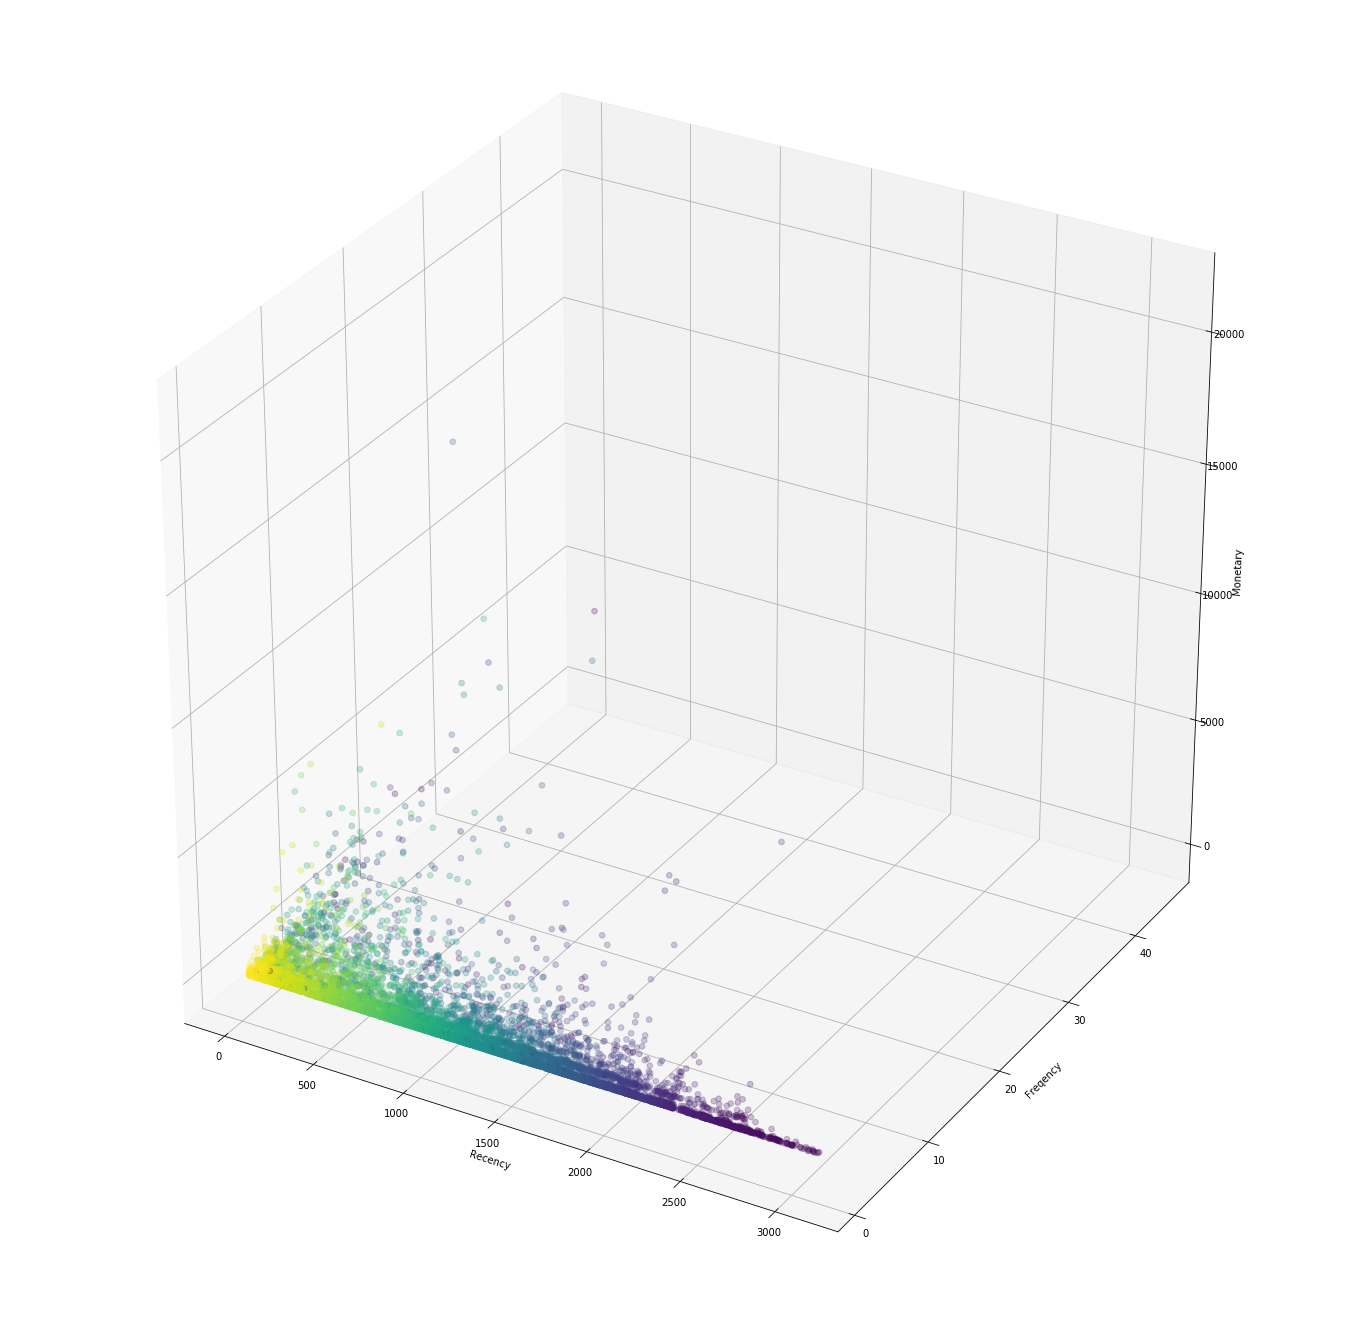

In [203]:
cl = tab.iloc[:,[1,2,3]] #podivame se na data
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cl['Recency'], cl['Freqency'],cl['Monetary'], s = 32, c=tab['Customer ID'], alpha = 0.25)
ax.set_xlabel('Recency')
ax.set_ylabel('Freqency')
ax.set_zlabel('Monetary')

In [204]:
# s pohledu je vedet, ze se hodnoty priznaku velmi lisi
# musime provest preskalovani ale o tom pak

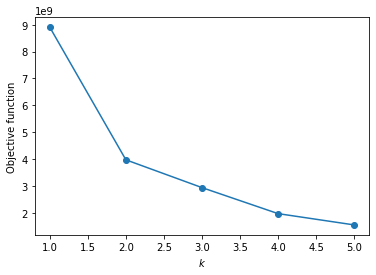

In [205]:
ix = np.zeros(5) #poprve se pokusime provest hlukovani na nepreskalovanyck datach
iy = np.zeros(5)
for k in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state = 1)
    kmeans.fit(cl)
    iy[k] = kmeans.inertia_
    ix[k] = k+1

plt.xlabel('$k$')
plt.ylabel('Objective function')
plt.plot(ix, iy, 'o-')
plt.show()

In [206]:
#vidime ze primka se zlomila na k=2
#takze pouzime kmeans a rozdelime data na 2 hluky

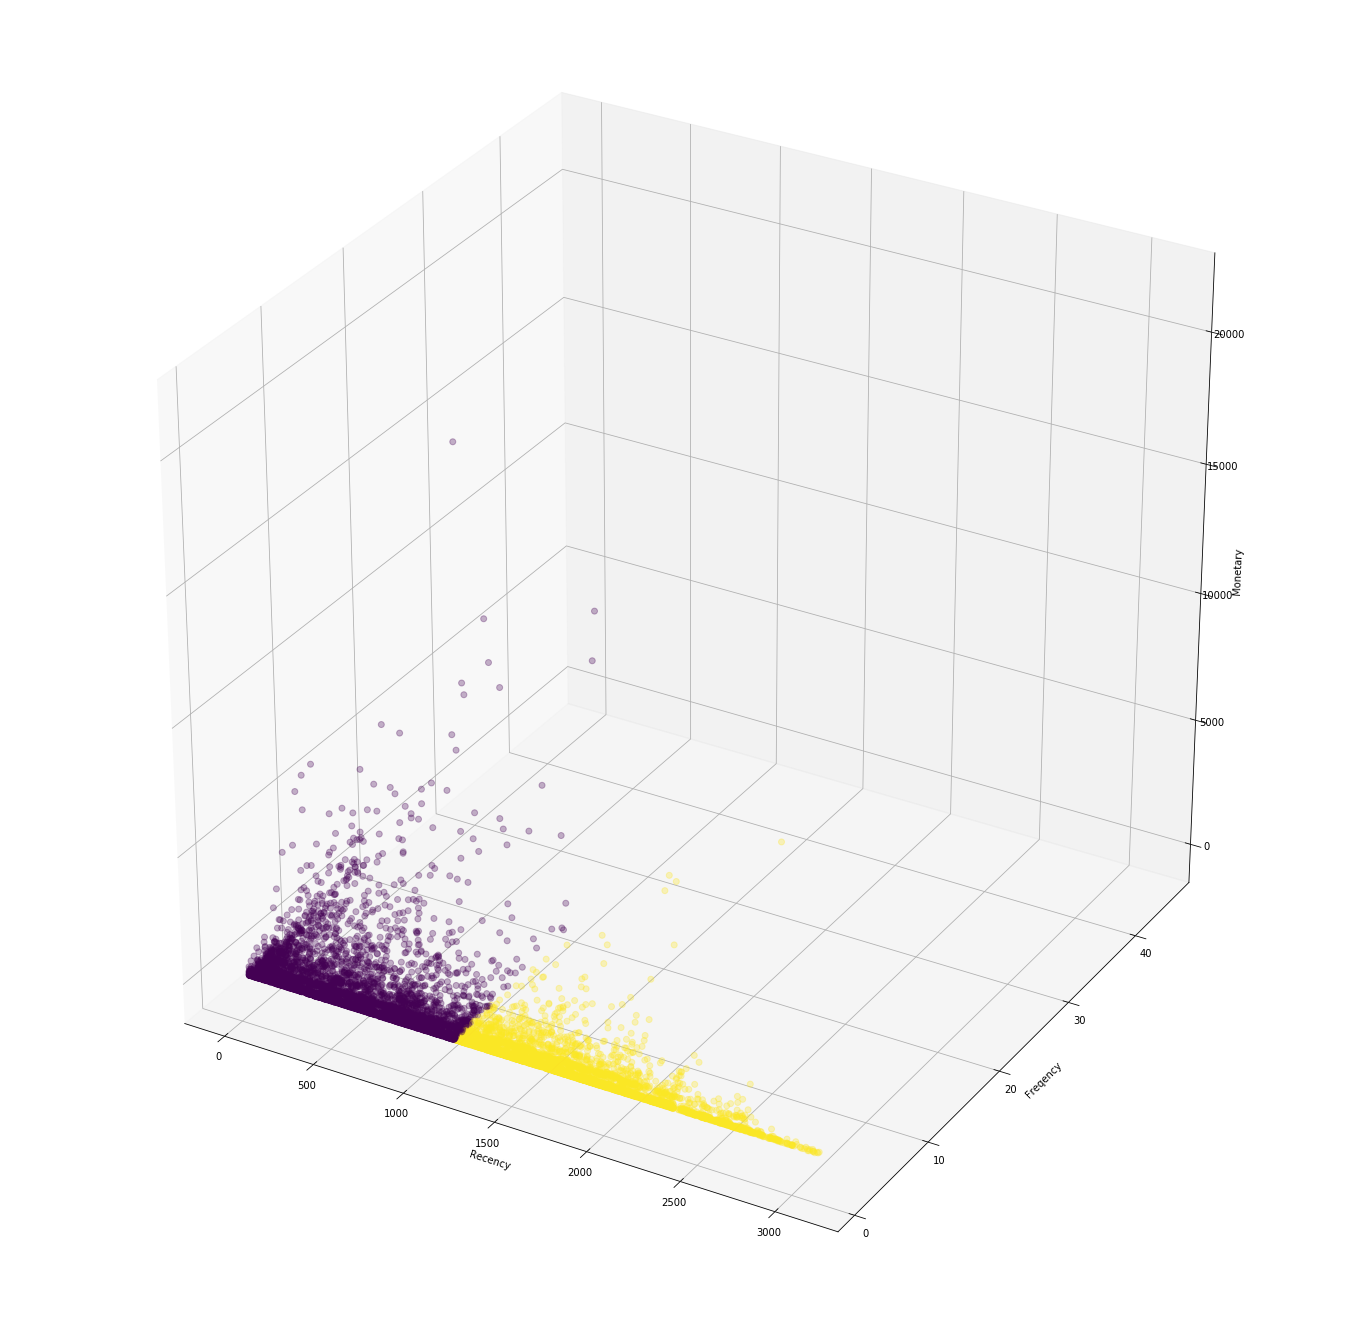

In [207]:
kmeans = KMeans(n_clusters = 2, random_state = 1).fit(cl)
kk = pd.Series(data=kmeans.labels_)
kk = kk.astype(int)
d = {'Recency': dates, 'Freqency': freq, 'Monetary': mon, 'nc': kk}
tab2 = pd.DataFrame(data = d)
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tab2['Recency'], tab2['Freqency'],tab2['Monetary'], s = 36, c=tab2['nc'], alpha = 0.3)
ax.set_xlabel('Recency')
ax.set_ylabel('Freqency')
ax.set_zlabel('Monetary')
plt.show()

In [208]:
#vypada to ze hlukovani se provedlo nejak nerozumne

In [209]:
#nastalo to kvuli neprovedeni skalovani dat
#mozna rict ze skalovani tady nemuzeme, ale musime udelat

Text(0.5, 0, 'Monetary')

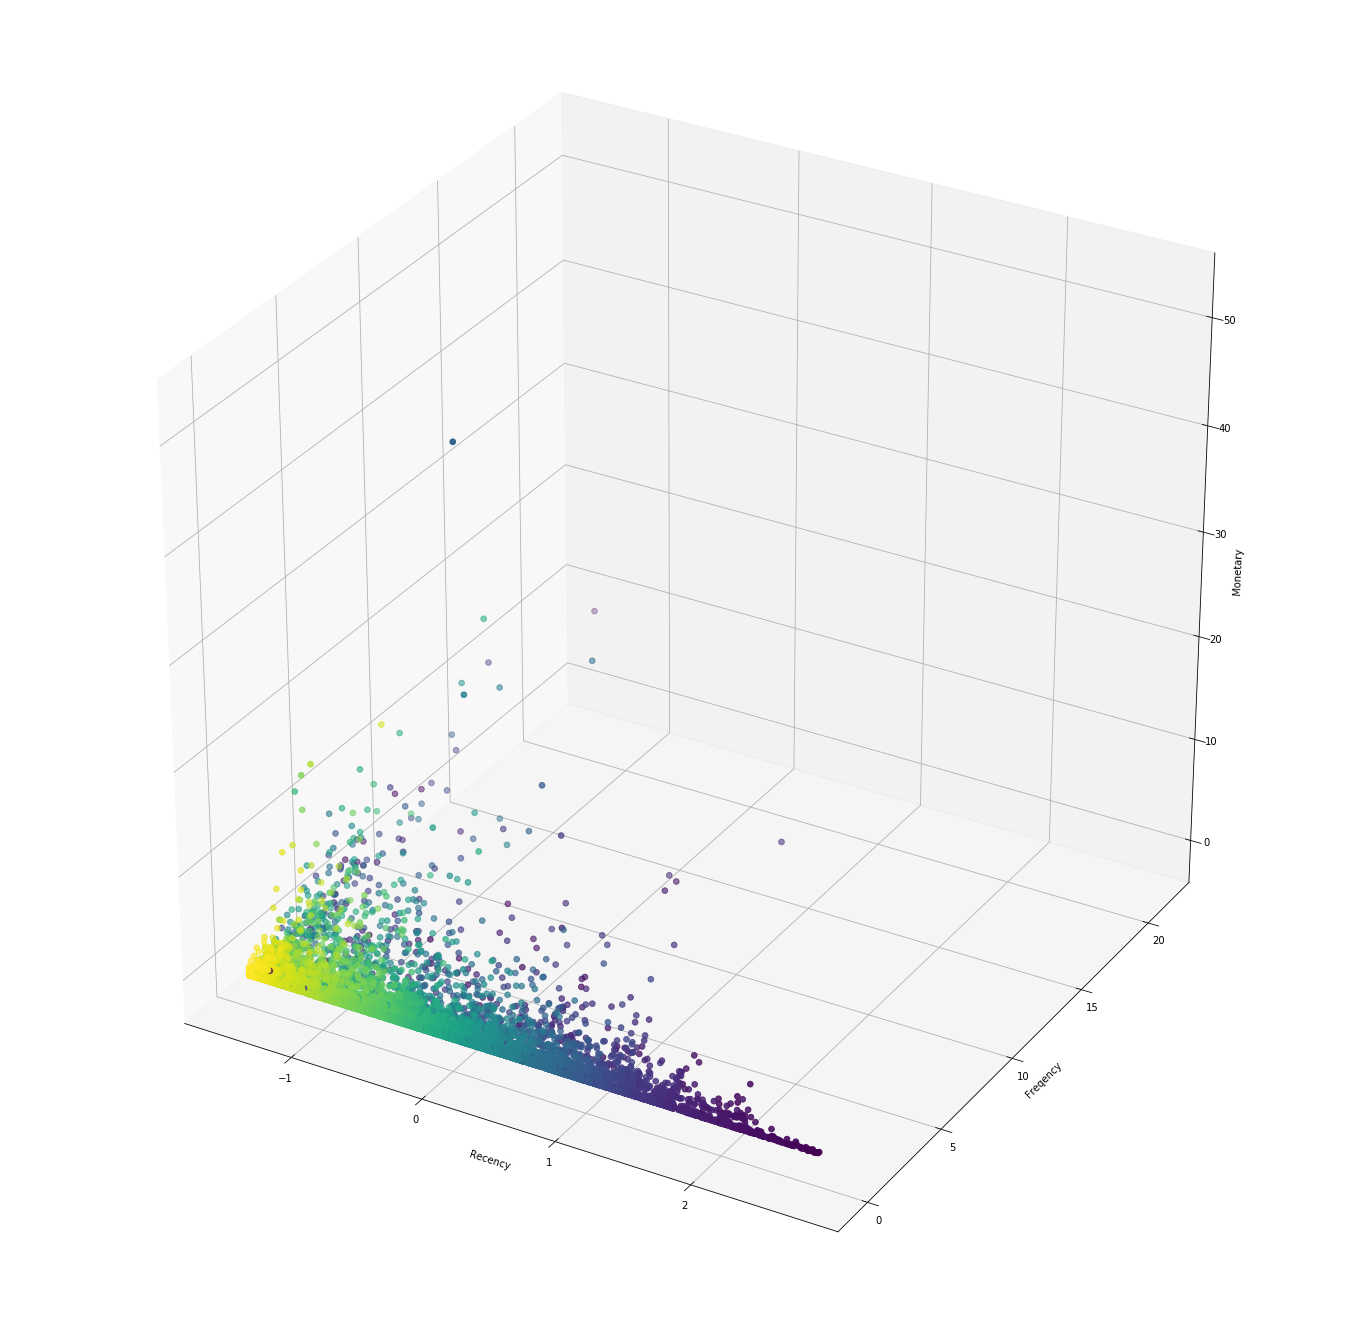

In [210]:
cl = tab.iloc[:,[1,2,3]] 
cl = preprocessing.scale(cl) #preskalujeme data
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cl[:,[0]], cl[:,[1]],cl[:,[2]], s = 32, c=tab['Customer ID'])
ax.set_xlabel('Recency')
ax.set_ylabel('Freqency')
ax.set_zlabel('Monetary')

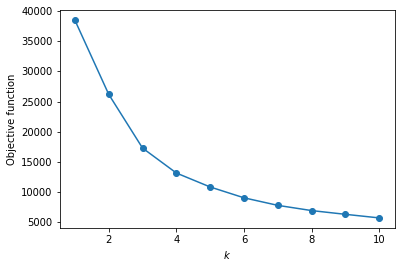

In [211]:
ix = np.zeros(10)
iy = np.zeros(10)
for k in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state = 1)
    kmeans.fit(cl)
    iy[k] = kmeans.inertia_
    ix[k] = k+1

plt.xlabel('$k$')
plt.ylabel('Objective function')
plt.plot(ix, iy, 'o-')
plt.show()

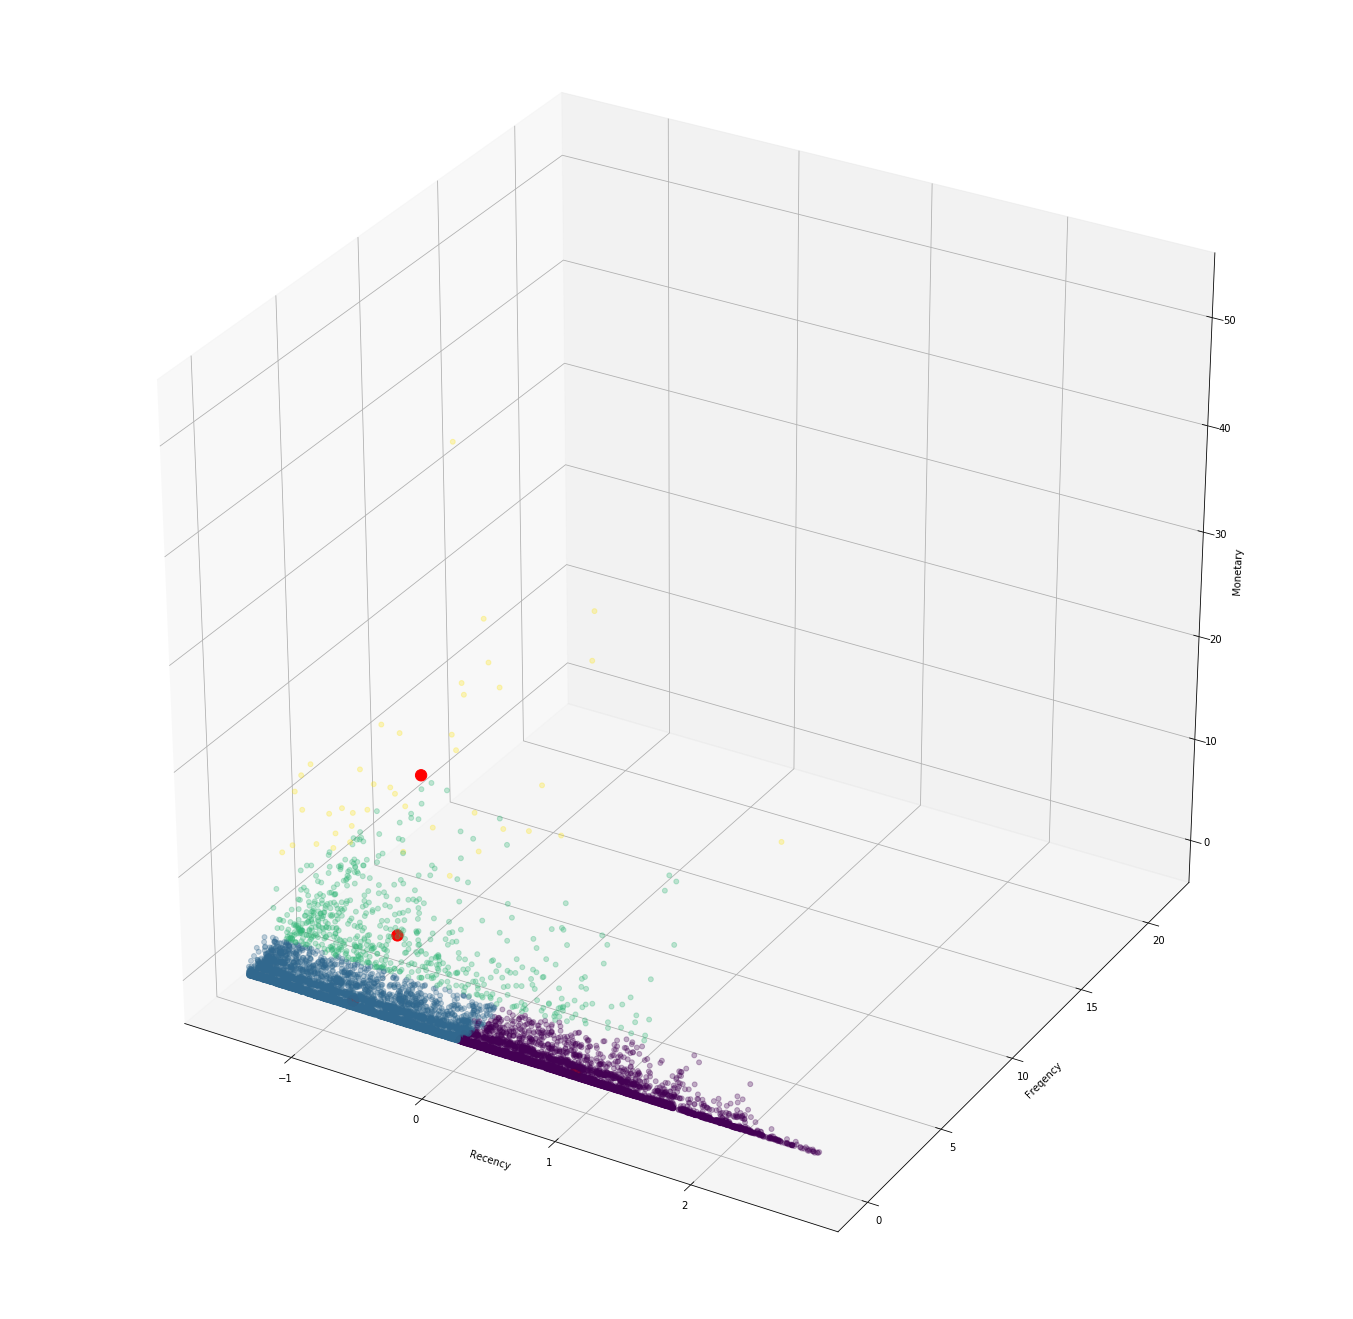

In [228]:
#polozime k=4
kmeans = KMeans(n_clusters = 4, random_state = 1).fit(cl)
kk = pd.Series(data=kmeans.labels_)
kk = kk.astype(int)
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cl[:,[0]], cl[:,[1]],cl[:,[2]], s = 24, c=kk, alpha = 0.3)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,2],s=128,alpha=1, c='Red')
ax.set_xlabel('Recency')
ax.set_ylabel('Freqency')
ax.set_zlabel('Monetary')
plt.show()

Text(0.5, 0, 'Monetary')

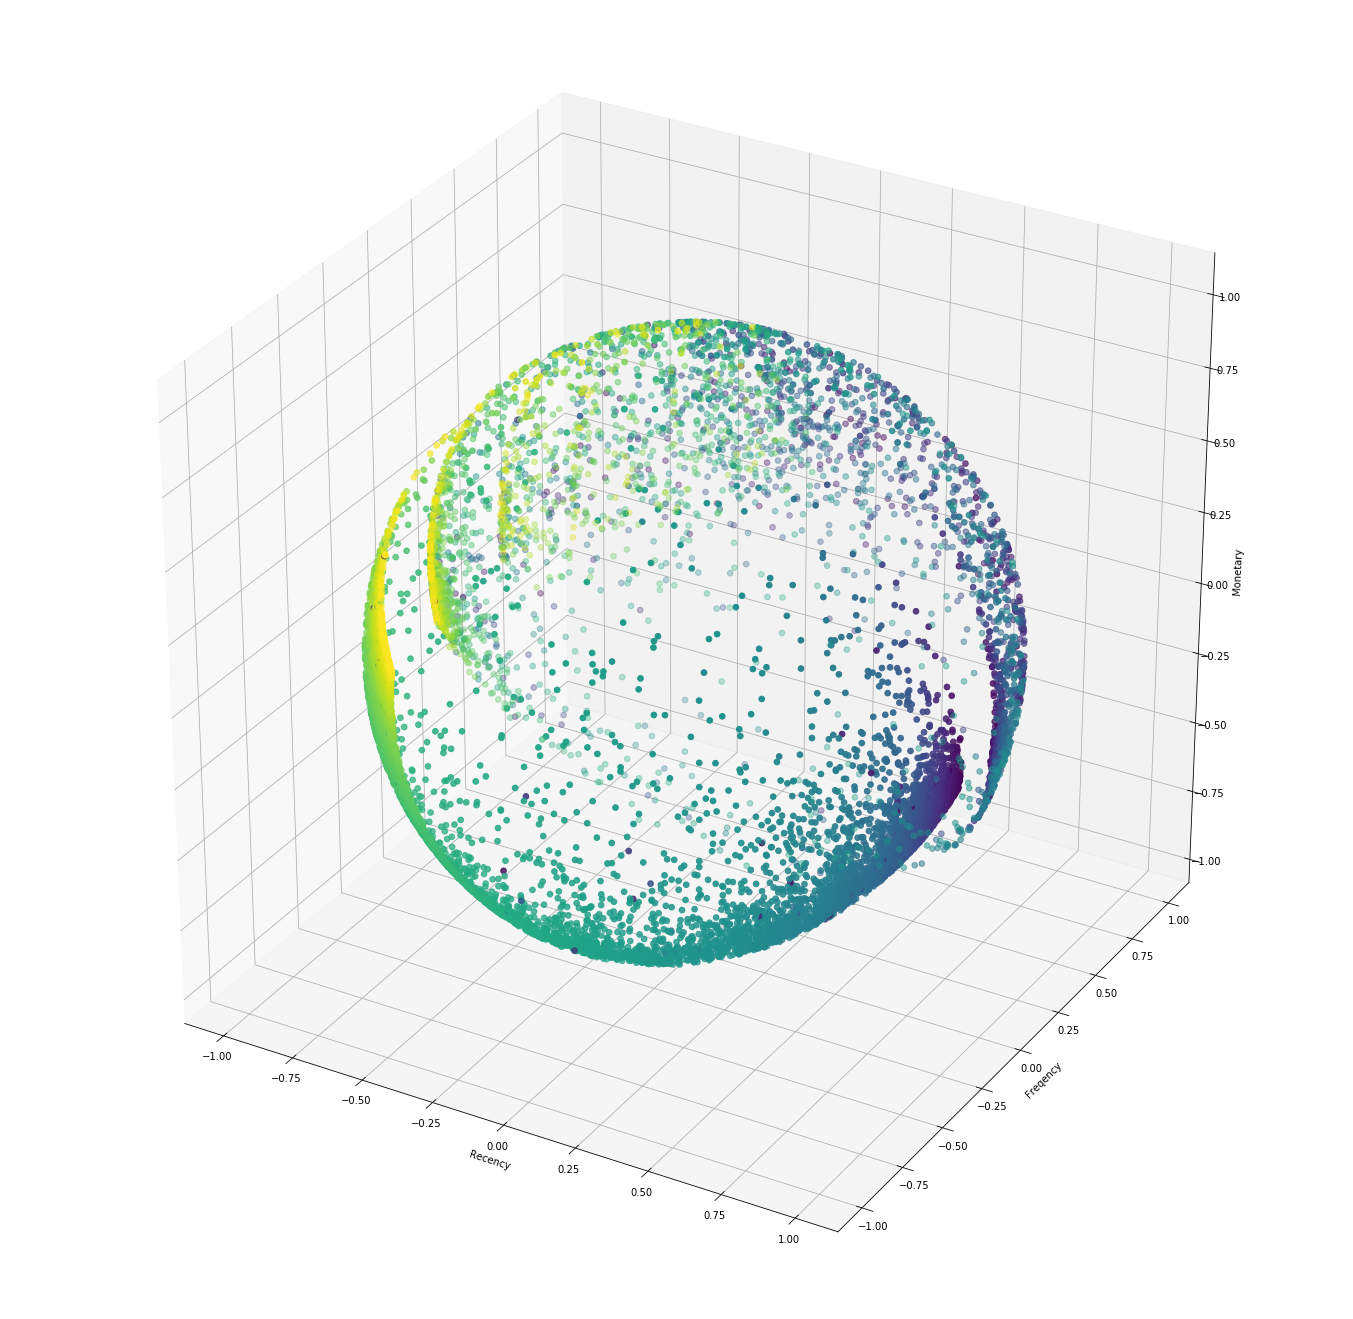

In [229]:
#ted'ka uz to dava smysl!
#pokusim se navic znormalizovat data
cl = tab.iloc[:,[1,2,3]] 
cl = preprocessing.normalize(preprocessing.scale(cl))
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cl[:,[0]], cl[:,[1]],cl[:,[2]], s = 32, c=tab['Customer ID'])
ax.set_xlabel('Recency')
ax.set_ylabel('Freqency')
ax.set_zlabel('Monetary')

In [230]:
#fantasticky obrazek

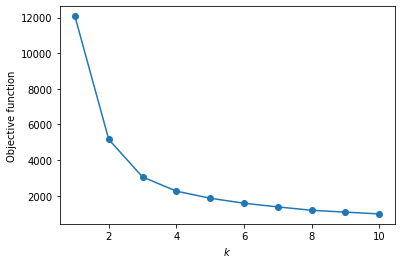

In [231]:
ix = np.zeros(10)
iy = np.zeros(10)
for k in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state = 1)
    kmeans.fit(cl)
    iy[k] = kmeans.inertia_
    ix[k] = k+1
plt.xlabel('$k$')
plt.ylabel('Objective function')
plt.plot(ix, iy, 'o-')
plt.show()

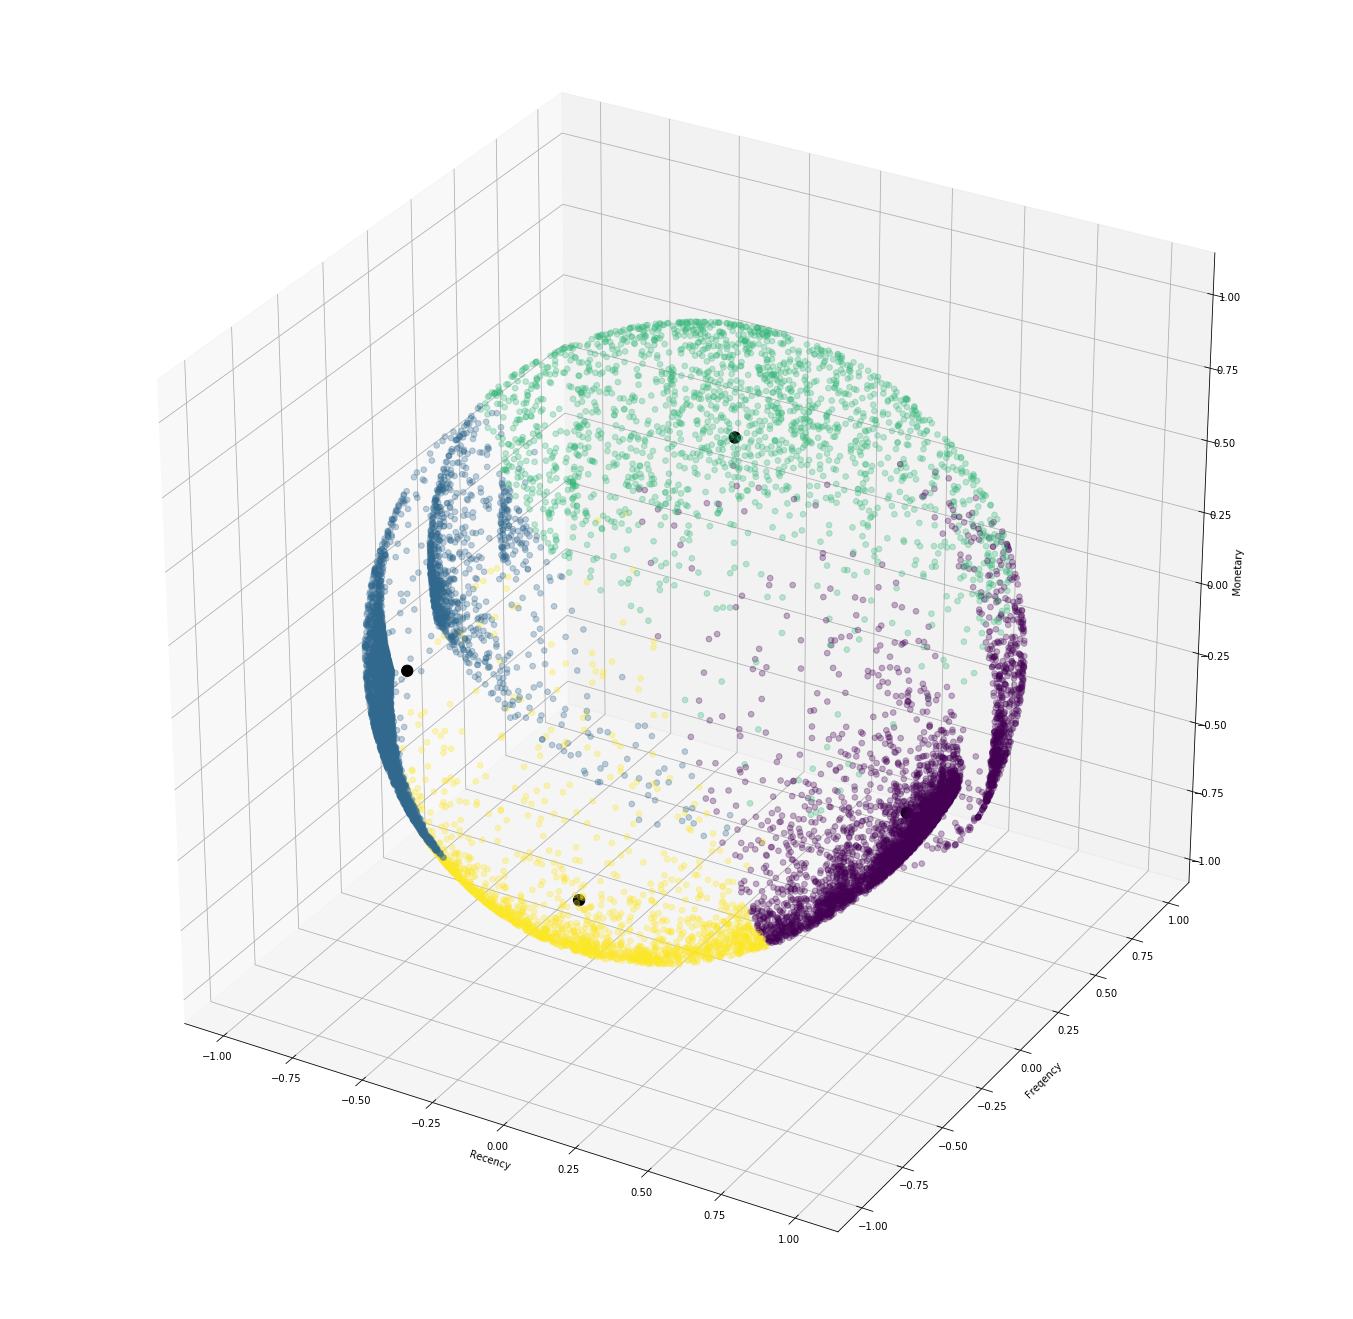

In [232]:
kmeans = KMeans(n_clusters = 4, random_state = 1).fit(cl)
kk = pd.Series(data=kmeans.labels_)
kk = kk.astype(int)
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cl[:,[0]], cl[:,[1]],cl[:,[2]], s = 32, c=kk, alpha = 0.3)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,2], s = 128, c='Black', alpha =1)
ax.set_xlabel('Recency')
ax.set_ylabel('Freqency')
ax.set_zlabel('Monetary')
plt.show()

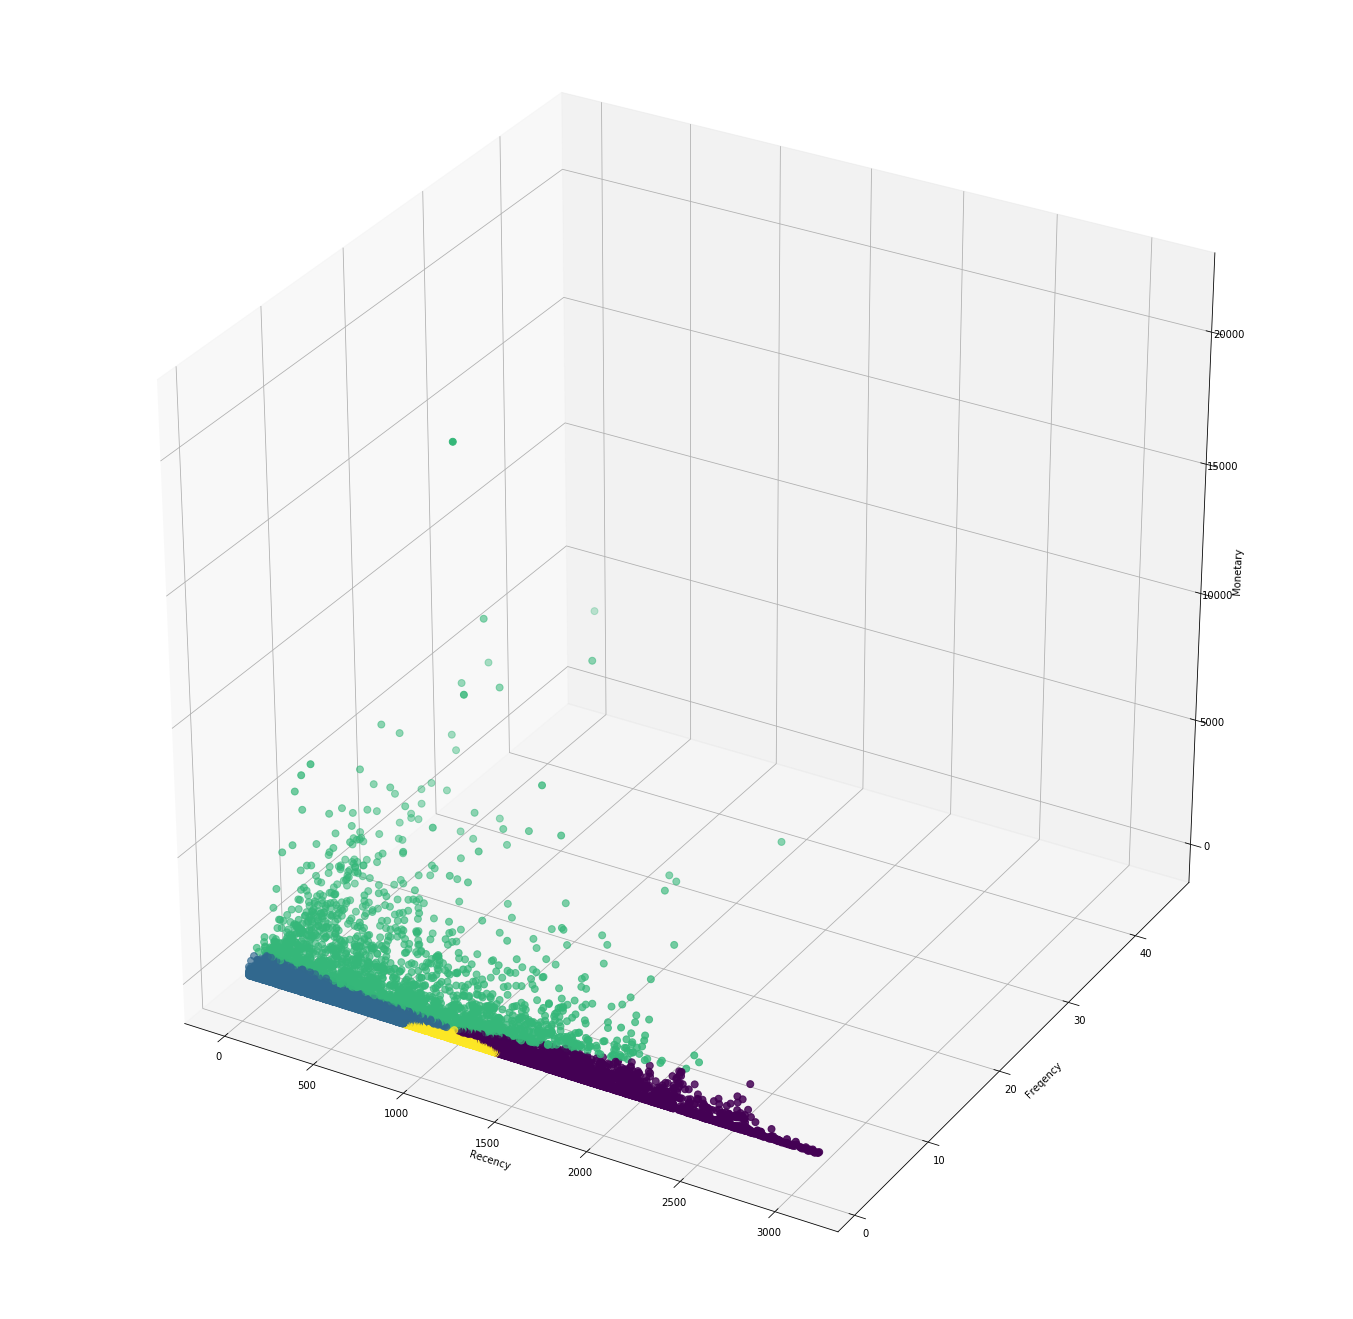

In [233]:
fig = plt.figure(figsize=(24,24)) #na puvodnich datach
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tab2['Recency'], tab2['Freqency'],tab2['Monetary'], s = 48, c=kk)
ax.set_xlabel('Recency')
ax.set_ylabel('Freqency')
ax.set_zlabel('Monetary')
plt.show()

In [142]:
#z vyslednych hluku je videt ze superstar zakazniky vetsinou jsou v zelenem hluku
#nezajimave v fiolovem

In [234]:
from sklearn.metrics import silhouette_score #ohodnotim hluky silhouette_score
clusterer = KMeans (n_clusters=2)
preds = clusterer.fit_predict(cl)
score = silhouette_score (cl, preds, metric='euclidean')
print ("Pro {} hluku, silhouette score se rovna {})".format(4, score))

Pro 4 hluku, silhouette score se rovna 0.5464715096325224)
